## Change Log
- Experiments can be setup by using the config parameter "experiment_variable" and assigning the experiment values as a list
- E.g. 
    - experiment_variable = "train_val_split"
    - config["training"]["train_val_split"] = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
- note: only parameters of the category "training" and "model_param" can be used

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN

## 0. Experiment Setup

In [4]:
# should an output folder be created to save the experiment data?
save_output = True
save_models = False

In [5]:
# read config file
import toml
config = toml.load("config.toml")

# determine experimental parameter from config
experiment_variable_values = ""
experiment_dict_key = ""
for category_name, category_values in config.items():
    if config["general"]["experiment_variable"] in category_values:
        experiment_variable_values = category_values[config["general"]["experiment_variable"]]
        experiment_dict_key = category_name
        
# rnd seed to support reproducable results
seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(2**32 -1)
random.seed(seed_value)
np.random.seed(seed_value)

# TabNet hyperparameters
experiment_variable = config["general"]["experiment_variable"]
regressor_param = {"optimizer_fn" : torch.optim.Adam,
                   "optimizer_params" : {"lr":0.05},
                   "scheduler_params" : {"step_size": 2, "gamma": 0.9},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                   "device_name" : 'cuda', # only working on NVIDIA GPUs
                   "verbose" : 0
                  }

# create experiment folder structure
if save_output or save_models:  
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = f"{experiment_name} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}" if experiment_name else f"{config['RQ2']['runs']}_runs_{config['general']['experiment_variable']} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}"
    
    experiment_path = os.path.join("Experiments", experiment_folder)
    os.mkdir(experiment_path)
    
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    models_path = os.path.join(experiment_path, "models")
    os.mkdir(models_path)
    
    # save config file
    import shutil
    shutil.copy2("config.toml", experiment_path)
    
    # save random seed
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        config_path = os.path.join(experiment_path, "config.toml")
        with open(config_path, "w") as f:
            toml.dump(config, f)
    
    # save model hyperparameters
    with open(os.path.join(experiment_path, 'config.toml'), 'a') as config_file:
        config_file.write("\n#[regressor_param]\n")
        for key, value in regressor_param.items(): 
            config_file.write('#%s = %s\n' % (key, str(value)))
    
    # create output file
    output_path = os.path.join(experiment_path, "output.toml")
    output_file = open(output_path, "w")

output = {}

## 1. Datasets

### 1.0. Use wine dataset

In [6]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import scale, StandardScaler

wine = load_wine()
X, y = pd.DataFrame(wine.data, columns=wine['feature_names']), wine.target
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=wine['feature_names'])

### 1.1. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [7]:
# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(X.columns), config["general"]["missing_percent"])}
X_mv = X.copy()

for f, mv in mv_config.items():
    X_mv[f] = X_mv[f].mask(np.random.random(X.shape[0]) < mv)

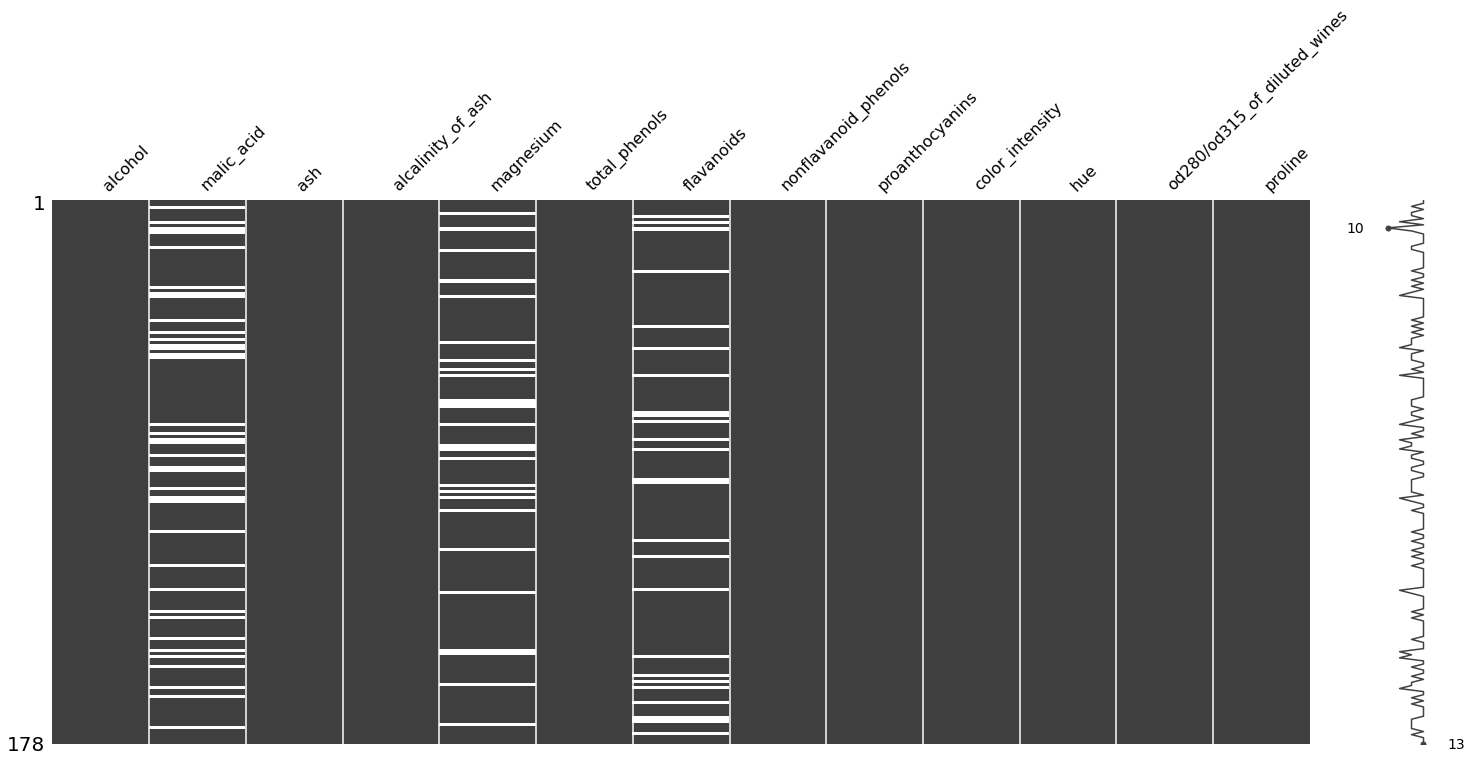

In [8]:
import missingno as msno
%matplotlib inline

# plot missing values
fig = msno.matrix(X_mv)
plt.show()
if save_output:
    #plt.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"])
    fig_copy = fig.get_figure()
    fig_copy.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"], bbox_inches = 'tight')

### 1.3. Initial Clustering (without missing values)
Automatically determine DBSCAN hyperparameters min_samples and eps.\
min_samples results in 26 for the wine dataset (dimensionality 13).\
for eps we choose 2 (elbow of the graph).

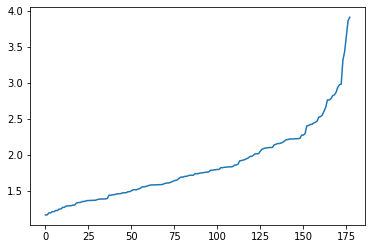

In [9]:
from sklearn.neighbors import NearestNeighbors

min_samples = 2 * len(X_scaled.columns)

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Use the cluster algorithm on dataset without missing values shows, that DBSCAN is not performaing well with 13 dimensional dataset (empty space problem leads to either 1 or 0 clusters).

In [10]:
# run DBSCAN on original data
config["DBSCAN"]["eps"] = 2
config["DBSCAN"]["min_samples"] = min_samples
if save_output or save_models:
    with open(config_path, "w") as f:
        toml.dump(config, f)

dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(X_scaled)
y_orig = dbscan_orig.labels_
print(f"DBSCAN noise: {(sum(abs(y_orig[y_orig == -1]))*100) / len(y)}%")

DBSCAN noise: 100.0%


As an alternative, we use k-means for the initial clustering (k=3). This does clearly work better with a more than 96% correct labeling of data.

In [11]:
from sklearn.cluster import KMeans
k_mean_orig = KMeans(n_clusters=3, random_state=seed_value).fit(X_scaled)
y_orig = k_mean_orig.labels_

In [12]:
from munkres import Munkres
from sklearn.metrics import confusion_matrix

# use Munkres / Hungarian algorithm to relabel clusters in order to match original label names
def make_cost_matrix(c1, c2):
    """
    """
    uc1 = np.unique(c1)
    uc2 = np.unique(c2)
    l1 = uc1.size
    l2 = uc2.size
    assert(l1 == l2 and np.all(uc1 == uc2))

    m = np.ones([l1, l2])
    for i in range(l1):
        it_i = np.nonzero(c1 == uc1[i])[0]
        for j in range(l2):
            it_j = np.nonzero(c2 == uc2[j])[0]
            m_ij = np.intersect1d(it_j, it_i)
            m[i,j] =  -m_ij.size
    return m

In [13]:
cost_matrix = make_cost_matrix(y_orig, y)
indexes = Munkres().compute(cost_matrix)
mapping = [new for (_, new) in indexes]
y_orig_renamed = np.choose(y_orig, mapping).astype(np.int64)

mislabeled = y - y_orig_renamed
mislabeled[mislabeled != 0] = 1
mislabeled_orig = sum(mislabeled) / len(mislabeled)
print(f"{round(mislabeled_orig * 100, 2)}% mislabeled")

3.37% mislabeled


Get cluster means for loss function input.

In [14]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = X.copy()
complete_data["C"] = y_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.
3. **KL Divergence Loss**\
Deviation of original distribution shall be minimized \
(prob distribution based on https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula \
number of bins: D. Freedman & P. Diaconis (1981) “On the histogram as a density estimator: L2 theory”. Probability Theory and Related Fields 57 (4): 453-476)

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [15]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error
import astropy.stats

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, y_name, x_val, y_val, cl_weights = [0.5, 1, 0.0001]):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = self.cluster_mean_loss(cluster_means, y_score, y_name, x_val, y_val)
        
        # KL divergence loss
        bins = len(astropy.stats.freedman_bin_width(y_true.reshape(1,-1)[0], return_bins=True)[1])
        distr1, distr2 = self.probability_dist(y_score, y_true, bins)
        KLdl = torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()
        
        # total loss
        custom_loss = cl_weights[0] * rmse + cl_weights[1] * KLdl + cl_weights[2] * cml
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, y_name, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = X.columns.get_loc(y_name)
        cols = cols[:feature_col] + cols[feature_col+1:] + [y_name]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)
    
    # calculate probabilities
    def probability_dist(self, x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(np.asarray(x)[:,0], np.asarray(y)[:,0], bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

### 2.2. Fill missing values (TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [16]:
import time

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = X_mv.columns[X_mv.isnull().any()]
X_reconstr = {}
output["costs"] = {}
output["runtimes"] = {}
output["predictions"] = {}

for run in range(config["RQ2"]["runs"]):
    
    print(f"Run {run + 1} / {config['RQ2']['runs']}")
    X_reconstr[run] = []
    output["costs"][f"run_{run}"] = {}
    output["runtimes"][f"run_{run}"] = {}
    output["predictions"][f"run_{run}"] = {}
    
    for i, experiment_value in enumerate(experiment_variable_values):
        
        config[experiment_dict_key][config["general"]["experiment_variable"]] = experiment_value
        
        time_start = time.time()
        X_reconstr[run].append(X_mv.copy())
        output["costs"][f"run_{run}"][str(experiment_value)] = {}
        output["runtimes"][f"run_{run}"][str(experiment_value)] = {}
        output["predictions"][f"run_{run}"][str(experiment_value)] = {}
        
        for feature in features_to_predict:
            
            # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
            n_features = math.ceil(config["RQ2"]["pred_features"] * (len(X_mv.columns)) - 1)
            X_mv_masked = X_mv.copy().drop(feature, axis=1).sample(n=n_features, axis='columns')
            other_features = X_mv_masked.columns

            # mask other columns' missing values as defined in config (missing_value_mask)
            X_mv_masked[feature] = X_mv[feature]
            X_mv_masked[other_features] = X_mv_masked[(other_features)].fillna(config["general"]["missing_value_mask"])

            # separate complete rows as train data
            # separate column with missing values as target
            test_data = X_mv_masked[X_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
            train_data = X_mv_masked[X_mv_masked[feature].notna()]
            train_features = train_data.drop(columns=feature).to_numpy()
            train_target = train_data[feature].to_numpy().reshape(-1,1)

            x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, train_size=config["training"]["train_val_split"])

            # create & train model
            model = TabNetRegressor(**regressor_param)
            if config["model_param"]["eval_metric"] == ["custom_loss"]:
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"],
                    cluster_means=cluster_means,
                    y_name=feature,
                    x_val=x_val,
                    y_val=y_val,
                    cl_weights=config["training"]["cl_weights"]
                )
            else:
                model.fit(
                    x_train, y_train,
                    eval_set=[(x_val, y_val)],
                    **config["model_param"]
                )     

            #track runtime
            time_end = time.time()

            # save costs
            output["costs"][f"run_{run}"][str(experiment_value)][feature] = model.best_cost

            # save predictions
            predictions = [x[0] for x in model.predict(test_data)]
            output["predictions"][f"run_{run}"][str(experiment_value)][feature] = predictions
            
            # fill missing values with model predictions
            X_reconstr[run][i].loc[X_reconstr[run][i][feature].isna(), feature] = predictions

            # save outputs
            if save_models:

                # save model
                torch.save(model, os.path.join(models_path, f"Model_run{run}_{config['general']['experiment_variable']}{experiment_value}_{feature}.pt"))
            
            if save_output:
                # save runtimes
                output["runtimes"][f"run_{run}"][str(experiment_value)][feature] = time_end - time_start


Run 1 / 100

Early stopping occurred at epoch 115 with best_epoch = 65 and best_val_0_rmse = 1.67362
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 13 and best_val_0_rmse = 39.09413
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.74476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 48 and best_val_0_rmse = 1.00893
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 8 and best_val_0_rmse = 57.86913
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.68164
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 242 with best_epoch = 192 and best_val_0_rmse = 1.12754
Best weights from be

Stop training because you reached max_epochs = 250 with best_epoch = 222 and best_val_0_rmse = 0.82984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 168 with best_epoch = 118 and best_val_0_rmse = 1.10219
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 31 and best_val_0_rmse = 42.35831
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.66829
Best weights from best epoch are automatically used!
Run 3 / 100
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.28674
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 56 and best_val_0_rmse = 22.78756
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse


Early stopping occurred at epoch 68 with best_epoch = 18 and best_val_0_rmse = 48.76971
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 29 and best_val_0_rmse = 0.78902
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.24466
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 28 and best_val_0_rmse = 53.48395
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 24 and best_val_0_rmse = 2.16247
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 46 and best_val_0_rmse = 1.3252
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 57 and best_val_0_rmse = 36.95594
Best weights from best epoch are automatically u


Early stopping occurred at epoch 102 with best_epoch = 52 and best_val_0_rmse = 32.7085
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.77298
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 242 with best_epoch = 192 and best_val_0_rmse = 1.18813
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 53 and best_val_0_rmse = 31.21633
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.58118
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.25527
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_rmse = 27.89027
Best weights fro


Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 1.87084
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 38 and best_val_0_rmse = 32.20355
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.3202
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 230 and best_val_0_rmse = 0.81066
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 12 and best_val_0_rmse = 44.69388
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 38 and best_val_0_rmse = 1.90766
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 220 and best_val_0_rmse = 1.08564
Best weights from be


Early stopping occurred at epoch 112 with best_epoch = 62 and best_val_0_rmse = 1.73899
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 39 and best_val_0_rmse = 28.09228
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.65046
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 5.7391
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 17 and best_val_0_rmse = 38.70232
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.81393
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 248 with best_epoch = 198 and best_val_0_rmse = 1.31949
Best weights from best epoch are 

Stop training because you reached max_epochs = 250 with best_epoch = 248 and best_val_0_rmse = 0.5514
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 236 and best_val_0_rmse = 1.25766
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 7 and best_val_0_rmse = 38.98297
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 208 and best_val_0_rmse = 0.71453
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 165 with best_epoch = 115 and best_val_0_rmse = 1.68929
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 36.06335
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 242 and best_val_0_rmse = 0.41743
Best


Early stopping occurred at epoch 73 with best_epoch = 23 and best_val_0_rmse = 38.05971
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.54855
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.32769
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 50 and best_val_0_rmse = 39.27635
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 167 with best_epoch = 117 and best_val_0_rmse = 0.77939
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 245 and best_val_0_rmse = 1.21874
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 59 and best_val_0_rmse = 32.91731
Best weights f

Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.68445
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 11 and best_val_0_rmse = 26.38601
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 226 and best_val_0_rmse = 0.61593
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 52 and best_val_0_rmse = 2.06199
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 26 and best_val_0_rmse = 17.34426
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.79697
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 27 and best_val_0_rmse = 3.11424
Best weights from 

Stop training because you reached max_epochs = 250 with best_epoch = 213 and best_val_0_rmse = 1.31274
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 86 and best_val_0_rmse = 29.82086
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.62736
Best weights from best epoch are automatically used!
Run 18 / 100

Early stopping occurred at epoch 188 with best_epoch = 138 and best_val_0_rmse = 1.03234
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 40.78402
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 19 and best_val_0_rmse = 3.97698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 3 and best_val_0_rmse = 4.40687
Best weights from be


Early stopping occurred at epoch 76 with best_epoch = 26 and best_val_0_rmse = 1.29701
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 49 and best_val_0_rmse = 42.31458
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 242 and best_val_0_rmse = 0.58203
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 12 and best_val_0_rmse = 4.74096
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 39 and best_val_0_rmse = 25.22658
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 21 and best_val_0_rmse = 3.50576
Best weights from best epoch are automatically used!
Run 20 / 100
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.3325
Best weights from best


Early stopping occurred at epoch 190 with best_epoch = 140 and best_val_0_rmse = 1.281
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 155 with best_epoch = 105 and best_val_0_rmse = 56.02611
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 226 and best_val_0_rmse = 0.6419
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 212 with best_epoch = 162 and best_val_0_rmse = 1.11123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 23.32443
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 61 and best_val_0_rmse = 1.1041
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 144 with best_epoch = 94 and best_val_0_rmse = 1.36894
Best weights from best epoch are automatically


Early stopping occurred at epoch 182 with best_epoch = 132 and best_val_0_rmse = 1.41311
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_rmse = 37.3816
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.57104
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 10 and best_val_0_rmse = 1.26677
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 28 and best_val_0_rmse = 29.85498
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 56 and best_val_0_rmse = 1.20935
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.98977
Best weights from best epoch are 


Early stopping occurred at epoch 79 with best_epoch = 29 and best_val_0_rmse = 1.3941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 1.89479
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 15 and best_val_0_rmse = 58.01367
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.78031
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.51744
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 8 and best_val_0_rmse = 22.07024
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 62 and best_val_0_rmse = 1.28973
Best weights from best epoch are au


Early stopping occurred at epoch 87 with best_epoch = 37 and best_val_0_rmse = 38.54245
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 17 and best_val_0_rmse = 1.05789
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 67 and best_val_0_rmse = 1.29273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 30 and best_val_0_rmse = 28.12746
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.71131
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 63 and best_val_0_rmse = 1.2384
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 48 and best_val_0_rmse = 19.78565
Best weights from best epoch are automatically 


Early stopping occurred at epoch 104 with best_epoch = 54 and best_val_0_rmse = 1.24231
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 23.64047
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 28 and best_val_0_rmse = 1.81701
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 2.79457
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 30 and best_val_0_rmse = 32.38579
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 62 and best_val_0_rmse = 0.78696
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 151 and best_val_0_rmse = 1.15021
Best weights from best epoch are automatically used!

Early s


Early stopping occurred at epoch 62 with best_epoch = 12 and best_val_0_rmse = 1.47923
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 2.72552
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 5 and best_val_0_rmse = 44.06357
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 95 and best_val_0_rmse = 1.63191
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 45 and best_val_0_rmse = 1.69335
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 17 and best_val_0_rmse = 33.69363
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 3 and best_val_0_rmse = 1.82873
Best weights from best epoch are automatically used!
Stop training

Stop training because you reached max_epochs = 250 with best_epoch = 237 and best_val_0_rmse = 0.50297
Best weights from best epoch are automatically used!
Run 33 / 100

Early stopping occurred at epoch 212 with best_epoch = 162 and best_val_0_rmse = 1.2147
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 40 and best_val_0_rmse = 28.20868
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.70515
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 107 and best_val_0_rmse = 1.12847
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 24 and best_val_0_rmse = 23.007
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 141 with best_epoch = 91 and best_val_0_rmse = 1.14011
Best weights from b


Early stopping occurred at epoch 139 with best_epoch = 89 and best_val_0_rmse = 44.68056
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 241 and best_val_0_rmse = 0.63573
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 239 and best_val_0_rmse = 1.71075
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 12 and best_val_0_rmse = 32.8801
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.59236
Best weights from best epoch are automatically used!
Run 35 / 100

Early stopping occurred at epoch 199 with best_epoch = 149 and best_val_0_rmse = 1.22454
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 52 and best_val_0_rmse = 24.10473
Be


Early stopping occurred at epoch 75 with best_epoch = 25 and best_val_0_rmse = 46.84066
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 48 and best_val_0_rmse = 1.58556
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 220 and best_val_0_rmse = 1.01615
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 11 and best_val_0_rmse = 45.14463
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 3.50318
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 49 and best_val_0_rmse = 1.07107
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 19.72061
Best weights from best epoch are automatically u


Early stopping occurred at epoch 57 with best_epoch = 7 and best_val_0_rmse = 29.71749
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.49141
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 22 and best_val_0_rmse = 4.11416
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 34 and best_val_0_rmse = 36.59967
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 224 and best_val_0_rmse = 0.66638
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 2.41351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 39 and best_val_0_rmse = 39.96773
Best weights from best epoch are a


Early stopping occurred at epoch 62 with best_epoch = 12 and best_val_0_rmse = 1.22098
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 19 and best_val_0_rmse = 37.18822
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.59123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 17 and best_val_0_rmse = 3.7675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 7 and best_val_0_rmse = 24.66616
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.59092
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 22 and best_val_0_rmse = 2.082
Best weights from best epoch are autom

Stop training because you reached max_epochs = 250 with best_epoch = 229 and best_val_0_rmse = 0.91228
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 11 and best_val_0_rmse = 21.57919
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.70345
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 65 and best_val_0_rmse = 1.15624
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 25 and best_val_0_rmse = 42.25445
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.82646
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 236 and best_val_0_rmse = 1.06233
Bes


Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 1.28196
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 7 and best_val_0_rmse = 7.76401
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 13 and best_val_0_rmse = 46.11727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 29 and best_val_0_rmse = 1.21247
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 52 and best_val_0_rmse = 1.53398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 18.65325
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.67621
Best weights from best epoch are automatically use

Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.63019
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 1 and best_val_0_rmse = 13.07215
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 60 and best_val_0_rmse = 44.20838
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 53 and best_val_0_rmse = 1.14776
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 163 with best_epoch = 113 and best_val_0_rmse = 1.316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 41 and best_val_0_rmse = 30.48584
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 170 with best_epoch = 120 and best_val_0_rmse = 0.84262
Best weights from best epoch are automaticall


Early stopping occurred at epoch 81 with best_epoch = 31 and best_val_0_rmse = 35.31648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 21 and best_val_0_rmse = 1.14829
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 11 and best_val_0_rmse = 3.2604
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 17.00376
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 153 and best_val_0_rmse = 0.62932
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 244 and best_val_0_rmse = 1.28243
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 36 and best_val_0_rmse = 39.4679
Best weights from best epoch are automatically u


Early stopping occurred at epoch 194 with best_epoch = 144 and best_val_0_rmse = 1.87447
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 47 and best_val_0_rmse = 47.57227
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 236 and best_val_0_rmse = 0.74926
Best weights from best epoch are automatically used!
Run 50 / 100
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.37125
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 10 and best_val_0_rmse = 35.10693
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 244 and best_val_0_rmse = 0.66156
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 3.63656
Best 


Early stopping occurred at epoch 123 with best_epoch = 73 and best_val_0_rmse = 1.60836
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 48 and best_val_0_rmse = 1.66792
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 19 and best_val_0_rmse = 47.67795
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.60969
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 28 and best_val_0_rmse = 3.51104
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 19 and best_val_0_rmse = 42.77237
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 15 and best_val_0_rmse = 2.42333
Best weights from best epoch are automatically u

Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.43248
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 139 with best_epoch = 89 and best_val_0_rmse = 1.48095
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 49 and best_val_0_rmse = 36.14837
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.60133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 10 and best_val_0_rmse = 1.63082
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 29.2567
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.71386
Best weights from b

Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.55761
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 2.39509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 38 and best_val_0_rmse = 31.52539
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.61032
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 14 and best_val_0_rmse = 2.20801
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 38 and best_val_0_rmse = 24.1924
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 229 and best_val_0_rmse = 0.46553
Best weights from bes


Early stopping occurred at epoch 74 with best_epoch = 24 and best_val_0_rmse = 26.59516
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 151 with best_epoch = 101 and best_val_0_rmse = 0.65271
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 240 with best_epoch = 190 and best_val_0_rmse = 0.91627
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 30.61423
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 233 and best_val_0_rmse = 0.5193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 3 and best_val_0_rmse = 2.17476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_rmse = 44.73724
Best weights from best epoch are automatically 


Early stopping occurred at epoch 72 with best_epoch = 22 and best_val_0_rmse = 52.52767
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.77204
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 103 and best_val_0_rmse = 1.33606
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 84 and best_val_0_rmse = 29.67621
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.99123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 13 and best_val_0_rmse = 1.36948
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 47 and best_val_0_rmse = 26.86
Best weights from best epoch are 


Early stopping occurred at epoch 81 with best_epoch = 31 and best_val_0_rmse = 1.5804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_rmse = 53.01463
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.75707
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 157 with best_epoch = 107 and best_val_0_rmse = 0.96644
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 18 and best_val_0_rmse = 13.14565
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.91849
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 100 and best_val_0_rmse = 0.76486
Best weights from best epoch are


Early stopping occurred at epoch 96 with best_epoch = 46 and best_val_0_rmse = 1.40231
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_rmse = 28.64727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 134 and best_val_0_rmse = 0.6682
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 46 and best_val_0_rmse = 2.84033
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 39 and best_val_0_rmse = 47.63186
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.57187
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 210 with best_epoch = 160 and best_val_0_rmse = 1.08415
Best weights from best epoch are automatically 

Stop training because you reached max_epochs = 250 with best_epoch = 230 and best_val_0_rmse = 1.0321
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 33 and best_val_0_rmse = 25.25581
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 33 and best_val_0_rmse = 0.97788
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_rmse = 3.20976
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 6 and best_val_0_rmse = 47.98965
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 2.15144
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 184 with best_epoch = 134 and best_val_0_rmse = 1.56567
Best weights from best epoch are automatically use


Early stopping occurred at epoch 238 with best_epoch = 188 and best_val_0_rmse = 1.2016
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 43 and best_val_0_rmse = 49.36595
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 162 with best_epoch = 112 and best_val_0_rmse = 0.78952
Best weights from best epoch are automatically used!
Run 67 / 100
Stop training because you reached max_epochs = 250 with best_epoch = 223 and best_val_0_rmse = 1.35205
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 38 and best_val_0_rmse = 50.45636
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 63 and best_val_0_rmse = 1.71384
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 5 and best_val_0_rmse = 3.57585
Best weights from best epoch are 

Stop training because you reached max_epochs = 250 with best_epoch = 248 and best_val_0_rmse = 1.49551
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 24 and best_val_0_rmse = 53.22658
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 9 and best_val_0_rmse = 1.93248
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 28 and best_val_0_rmse = 2.18936
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 19 and best_val_0_rmse = 38.72775
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 1.79652
Best weights from best epoch are automatically used!
Run 69 / 100
Stop training because you reached max_epochs = 250 with best_epoch = 246 and best_val_0_rmse = 0.92425
Best weights from best


Early stopping occurred at epoch 99 with best_epoch = 49 and best_val_0_rmse = 1.12327
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 62 and best_val_0_rmse = 53.18201
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.64505
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 13 and best_val_0_rmse = 2.52267
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 31 and best_val_0_rmse = 57.62071
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.72833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 41 and best_val_0_rmse = 1.49829
Best weights from best epoch are 


Early stopping occurred at epoch 64 with best_epoch = 14 and best_val_0_rmse = 1.60035
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 43.80984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 46 and best_val_0_rmse = 1.68043
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 222 and best_val_0_rmse = 1.5226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 41 and best_val_0_rmse = 41.85114
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.49081
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.24608
Best weights from be


Early stopping occurred at epoch 65 with best_epoch = 15 and best_val_0_rmse = 3.4579
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 20 and best_val_0_rmse = 46.11857
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.61415
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.19387
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 5 and best_val_0_rmse = 44.65299
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 66 and best_val_0_rmse = 1.0991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 183 with best_epoch = 133 and best_val_0_rmse = 1.31699
Best weights from best epoch are a


Early stopping occurred at epoch 175 with best_epoch = 125 and best_val_0_rmse = 2.2949
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 40 and best_val_0_rmse = 53.10073
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.58316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 11 and best_val_0_rmse = 2.18372
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 14 and best_val_0_rmse = 28.97897
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 247 and best_val_0_rmse = 0.56184
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 103 and best_val_0_rmse = 1.16704
Best weights from best epoch ar


Early stopping occurred at epoch 100 with best_epoch = 50 and best_val_0_rmse = 2.70158
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 17 and best_val_0_rmse = 44.86194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 34 and best_val_0_rmse = 0.87852
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 242 and best_val_0_rmse = 0.88022
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 7 and best_val_0_rmse = 36.58042
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 14 and best_val_0_rmse = 1.57262
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.90741
Best weights from best epoch are a

Stop training because you reached max_epochs = 250 with best_epoch = 245 and best_val_0_rmse = 0.6057
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 11 and best_val_0_rmse = 6.19739
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 29.99483
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.63619
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 15 and best_val_0_rmse = 2.97398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 19 and best_val_0_rmse = 27.50492
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.557
Best weights from best

Stop training because you reached max_epochs = 250 with best_epoch = 227 and best_val_0_rmse = 0.53232
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 80 and best_val_0_rmse = 1.51553
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 17 and best_val_0_rmse = 31.69867
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 53 and best_val_0_rmse = 1.79802
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 149 and best_val_0_rmse = 1.0234
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 35 and best_val_0_rmse = 26.42484
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 49 and best_val_0_rmse = 1.3954
Best weights from best epoch are automatically 

Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.6577
Best weights from best epoch are automatically used!
Run 84 / 100

Early stopping occurred at epoch 73 with best_epoch = 23 and best_val_0_rmse = 1.57132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 28 and best_val_0_rmse = 38.97954
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.73141
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 139 with best_epoch = 89 and best_val_0_rmse = 1.11325
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 149 with best_epoch = 99 and best_val_0_rmse = 41.04772
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 132 with best_epoch = 82 and best_val_0_rmse = 1.0034
Best weights from be


Early stopping occurred at epoch 81 with best_epoch = 31 and best_val_0_rmse = 31.48334
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 127 and best_val_0_rmse = 0.82504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 17 and best_val_0_rmse = 1.46056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 42 and best_val_0_rmse = 26.38967
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 226 and best_val_0_rmse = 0.72902
Best weights from best epoch are automatically used!
Run 86 / 100

Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_rmse = 17.97453
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 122 with best_epoch = 72 and best_val_0_rmse = 24.87276
Best weights from best epoch are


Early stopping occurred at epoch 105 with best_epoch = 55 and best_val_0_rmse = 30.31233
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.53305
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.08558
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 48 and best_val_0_rmse = 36.46432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 65 and best_val_0_rmse = 0.95402
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 235 with best_epoch = 185 and best_val_0_rmse = 0.75164
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 34 and best_val_0_rmse = 36.01325
Best weights from best epoch 


Early stopping occurred at epoch 87 with best_epoch = 37 and best_val_0_rmse = 22.5947
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 61 and best_val_0_rmse = 1.11117
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 163 and best_val_0_rmse = 1.65452
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 140 with best_epoch = 90 and best_val_0_rmse = 37.01882
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 21 and best_val_0_rmse = 1.17188
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 177 with best_epoch = 127 and best_val_0_rmse = 1.16269
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 40 and best_val_0_rmse = 40.17958
Best weights from best epoch are automatically used!
Stop 


Early stopping occurred at epoch 89 with best_epoch = 39 and best_val_0_rmse = 23.84422
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.6927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 209 with best_epoch = 159 and best_val_0_rmse = 1.30634
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_rmse = 63.39601
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.54163
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 184 and best_val_0_rmse = 0.87392
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 118 with best_epoch = 68 and best_val_0_rmse = 43.19884
Best weights from best epoch a


Early stopping occurred at epoch 118 with best_epoch = 68 and best_val_0_rmse = 22.9318
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 216 and best_val_0_rmse = 0.58773
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 23 and best_val_0_rmse = 1.10981
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 12 and best_val_0_rmse = 23.0314
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.74848
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 1.54641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 67 and best_val_0_rmse = 28.74156
Best weights from 


Early stopping occurred at epoch 109 with best_epoch = 59 and best_val_0_rmse = 1.0939
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 39 and best_val_0_rmse = 37.66958
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 230 and best_val_0_rmse = 0.66143
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 32 and best_val_0_rmse = 1.49959
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 55 and best_val_0_rmse = 16.26328
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 37 and best_val_0_rmse = 1.1016
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 246 with best_epoch = 196 and best_val_0_rmse = 0.9869
Best weights from best epoch are automatically u


Early stopping occurred at epoch 68 with best_epoch = 18 and best_val_0_rmse = 6.28622
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 18 and best_val_0_rmse = 39.78654
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.48641
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 184 and best_val_0_rmse = 0.93025
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 16 and best_val_0_rmse = 34.73444
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 250 with best_epoch = 249 and best_val_0_rmse = 0.67986
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 131 and best_val_0_rmse = 0.90776
Best weights from best epoch a

Stop training because you reached max_epochs = 250 with best_epoch = 207 and best_val_0_rmse = 0.91396
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 67 and best_val_0_rmse = 43.49967
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 162 with best_epoch = 112 and best_val_0_rmse = 0.76191
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 149 and best_val_0_rmse = 1.90087
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 128 with best_epoch = 78 and best_val_0_rmse = 17.04798
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 10 and best_val_0_rmse = 1.50372
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 245 with best_epoch = 195 and best_val_0_rmse = 1.51546
Best weights from best epoch are automati


Early stopping occurred at epoch 80 with best_epoch = 30 and best_val_0_rmse = 1.28093
Best weights from best epoch are automatically used!


## 3. Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [17]:
best_per_run = []
best_per_run_index = []
for run in range(config["RQ2"]["runs"]):
    cost_list = list(output["costs"][f"run_{run}"].values())
    cost_totals = [sum(c**2 for c in list(x.values())) for x in cost_list]
    best_per_run.append(min(cost_totals))
    best_per_run_index.append(cost_totals.index(min(cost_totals)))
    
best_run = best_per_run.index(min(best_per_run))
best_model = best_per_run_index[best_run]
print(f"Best model: run {best_run} model {best_model}")

X_best = X_reconstr[best_run][best_model]

Best model: run 36 model 3


## 4. Clustering
Apply k-means (k=3) on reconstructed data. In order to make the clusters comparable, the k-Means labels will be replaced using Munkres / Hungarian algorithm as explained here:\
https://gist.github.com/siolag161/dc6e42b64e1bde1f263b \
https://github.com/benchaplin/hungarian-algorithm

In [ ]:
# apply clustering
y_reconstr = []
for run in range(config["RQ2"]["runs"]):
    y_reconstr.append([])
    for i, var in enumerate(experiment_variable_values):
        
        X_reconstr_scaled = pd.DataFrame(StandardScaler().fit_transform(X_reconstr[run][i]))
        k_mean_reconstr = KMeans(n_clusters=3).fit(X_reconstr_scaled)
        
        cost_matrix = make_cost_matrix(k_mean_reconstr.labels_, y)
        indexes = Munkres().compute(cost_matrix)
        mapping = [new for (_, new) in indexes]
        
        y_reconstr[run].append(np.choose(k_mean_reconstr.labels_,mapping).astype(np.int64))

## 5. Cluster Performance


### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots based on best model predictions

In [ ]:
# plot distributions
bins = len(astropy.stats.freedman_bin_width(X[feature], return_bins=True)[1])
n_feat = len(features_to_predict) if len(features_to_predict) > 1 else 2

fig, (ax) = plt.subplots(n_feat, 2, figsize=(10,n_feat*3))
fig.suptitle(f"distributions based on best model", fontweight='bold')
for n, feature in enumerate(X_best[features_to_predict]):
    ax[n, 0].hist(X[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(X_best[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_reconstructed")

fig.tight_layout()
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "feature distributions.png"), **config["plots"])

#### 5.1.1 Predictions out of original min/max range

In [ ]:
data = {}

for feature in features_to_predict:
    data[feature] = {}
    n_predictions = sum(X_mv[feature].isna()) * config["RQ2"]["runs"]
    min_val = X[feature].min()
    max_val = X[feature].max()
    n_inliers = 0
    
    for experiment_value in experiment_variable_values:
        data[feature][str(experiment_value)] = 0  
        
        for run in range(config["RQ2"]["runs"]):
            data[feature][str(experiment_value)] += sum([True if x > min_val and x < max_val else False for x in output["predictions"][f"run_{run}"][str(experiment_value)][feature]])
    
        data[feature][str(experiment_value)] = data[feature][str(experiment_value)] / n_predictions

n_features = len(features_to_predict) if len(features_to_predict) > 1 else 2
base_height = 5
base_width = 2
fontsize=20

fig, axs = plt.subplots(n_features, figsize=(len(experiment_variable_values)*base_width,n_features*base_height))
fig.suptitle(f"% of predicted values within original range", fontweight='bold',fontsize=fontsize)

for nr, feature in enumerate(features_to_predict):
    axs[nr].plot(data[feature].keys(), data[feature].values())
    axs[nr].set_xlabel(config["general"]["experiment_variable"],fontsize=fontsize)
    axs[nr].set_ylabel(feature, fontweight='bold', fontsize=fontsize)
    axs[nr].set_ylim([0, 1])
    axs[nr].text(0.9, 0.9, f"{[x for x in config['general']['missing_percent'] if x != 0][nr]}% missing", horizontalalignment='center', verticalalignment='center', transform=axs[nr].transAxes, fontsize=30)

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_prediction_range_rel.png"), **config["plots"])

plt.show()

In [ ]:
data = {}
for feature in features_to_predict:
    data[feature] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        # add all replaced values from all runs to a list
        data[feature][str(experiment_value)] = []
        for run in range(config["RQ2"]["runs"]): 
            data[feature][str(experiment_value)].extend(output["predictions"][f"run_{run}"][str(experiment_value)][feature])

nr_features = len(features_to_predict) if len(features_to_predict) > 1 else 2
base_height = 10
base_width = 3
fontsize=20

fig, axs = plt.subplots(nr_features, figsize=(len(experiment_variable_values)*base_width,nr_features*base_height))
fig.suptitle(f"Predicted values", fontweight='bold',fontsize=fontsize)

for nr, feature in enumerate(features_to_predict):
    axs[nr].boxplot(data[feature].values(), patch_artist = True)
    axs[nr].set_xticklabels(data[feature].keys(),fontsize=fontsize)
    axs[nr].set_xlabel(config["general"]["experiment_variable"],fontsize=fontsize)
    axs[nr].set_ylabel(feature, fontweight='bold', fontsize=fontsize)
    axs[nr].axhline(X[feature].min(),color='red',ls='-')
    axs[nr].axhline(X[feature].max(),color='red',ls='-')
    axs[nr].text(0.9, 0.9, f"min {X[feature].min()}\nmax {X[feature].max()}", horizontalalignment='center', verticalalignment='center', transform=axs[nr].transAxes, fontsize=30)

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_prediction_range_abs.png"), **config["plots"])

plt.show()

#### 5.1.2 KL Divergence

In [ ]:
# KL Divergence
def kl_divergence(feature1, feature2):
    
    # calculate probability distributions
    def probability_dist(x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(x, y, bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

    # calculate kl divergence
    bins = len(astropy.stats.freedman_bin_width(feature1, return_bins=True)[1])
    distr1, distr2 = probability_dist(feature1, feature2, bins)
    return torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()

In [ ]:
output["kl_divergence"] = {}

# save kl divergence
for run in range(config["RQ2"]["runs"]):
    output["kl_divergence"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        output["kl_divergence"][f"run_{run}"][str(experiment_value)] = {}
        for feature in features_to_predict:
            output["kl_divergence"][f"run_{run}"][str(experiment_value)][feature] = kl_divergence(X[feature], X_reconstr[run][i][feature])

In [ ]:
# plot
data = {}
for feature in features_to_predict:
    data[feature] = {}
    for experiment_value in experiment_variable_values:
        data[feature][str(experiment_value)] = [x[str(experiment_value)][feature] for x in output["kl_divergence"].values()]

nr_features = len(features_to_predict) if len(features_to_predict) > 1 else 2
fig, axs = plt.subplots(nr_features, figsize=(len(experiment_variable_values)*3,nr_features*4))
fig.suptitle(f"KL divergence, {config['RQ2']['runs']} runs", fontweight='bold')

for nr, feature in enumerate(features_to_predict):
    axs[nr].boxplot(data[feature].values(), patch_artist = True) # , showfliers=False
    axs[nr].set_xticklabels(data[feature].keys())
    axs[nr].set_xlabel(config["general"]["experiment_variable"])
    axs[nr].set_ylabel(feature, fontweight='bold')

plt.tight_layout() 

if save_output:
    plt.savefig(os.path.join(plots_path, "5_kl_divergence.png"), **config["plots"])
    
plt.show()

### 5.2 Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

output["silhouette_scores"] = {}
output["silhouette_scores"]["orig_data"] = float(silhouette_score(X, np.ravel(y)))

for run in range(config["RQ2"]["runs"]):
    output["silhouette_scores"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        if len(np.unique(y_reconstr[run][i])) > 1:
            output["silhouette_scores"][f"run_{run}"][str(experiment_value)] = float(silhouette_score(X_reconstr[run][i], y_reconstr[run][i]))
        else:
            output["silhouette_scores"][f"run_{run}"][str(experiment_value)] = np.nan

In [ ]:
# plot
sil_scores = output["silhouette_scores"].copy()
del(sil_scores["orig_data"])

data = {}
for experiment_value in experiment_variable_values:
    data[str(experiment_value)] = [x[str(experiment_value)] for x in sil_scores.values()]

fig, ax = plt.subplots()
ax.boxplot(data.values(), patch_artist = True)
ax.set_xticklabels(data.keys())
plt.axhline(y=output['silhouette_scores']['orig_data'], color='r', linestyle='-')
plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("silhouette score")
plt.title(f"silhouette scores, {config['RQ2']['runs']} runs\noriginal data: {round(output['silhouette_scores']['orig_data'], 2)}")

if save_output:
    plt.savefig(os.path.join(plots_path, "5_silhouette_scores.png"), **config["plots"])

plt.show()

### 5.3. ARI Score

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

output["ARI_score"] = {}
output["ARI_score"]["orig_data"] = adjusted_rand_score(y_orig, y)

for run in range(config["RQ2"]["runs"]):
    output["ARI_score"][f"run_{run}"] = {}
    for i, experiment_value in enumerate(experiment_variable_values):
        ari = adjusted_rand_score(y_reconstr[run][i], y)
        output["ARI_score"][f"run_{run}"][str(experiment_value)] = ari

In [ ]:
# plot
ari = output["ARI_score"].copy()
del(ari['orig_data'])

data = {}
for experiment_value in experiment_variable_values:
    data[str(experiment_value)] = [x[str(experiment_value)] for x in ari.values()]

fig, ax = plt.subplots()
ax.boxplot(data.values(), patch_artist = True)
ax.set_xticklabels(data.keys())
plt.axhline(y=output['ARI_score']['orig_data'], color='r', linestyle='-')
plt.xlabel(config["general"]["experiment_variable"])
plt.ylabel("ARI Score")
plt.title(f"ARI Score, {config['RQ2']['runs']} runs")

if save_output:
    plt.savefig(os.path.join(plots_path, "5_ARI-score.png"), **config["plots"])

plt.show()

### 5.5. Save Output

In [ ]:
if save_output:
    # save output file
    with open(output_path, "w") as f:
                toml.dump(output, f)

    # save notebook
    shutil.copy2(nb_name, experiment_path)